<a href="https://colab.research.google.com/github/shilewenuw/DeepMeanReversion/blob/main/DeepMeanReversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is an OU (Ornstein-Uhlenbeck) Process?
Most people know what Neural Networks are, but most people might not know what an OU Process is. An OU Process is a mean-reverting stochastic process. That means that it tends not to trend upwards (think of a time-series of human population) or downwards (think of a time-series of acres of forest coverage), rather, it wants to revolve around some average value.
The equation for this process is:  
$$dx_t=\mu(\theta-x_t)dt+\sigma dW_t$$ where $dW_t$ denotes a Brownian or Wiener process.  
Note: we use $\mu$ for drift and $\theta$ for mean instead of the other way around as parts of this algorithm is based on [this](https://arxiv.org/pdf/1411.5062.pdf) paper.
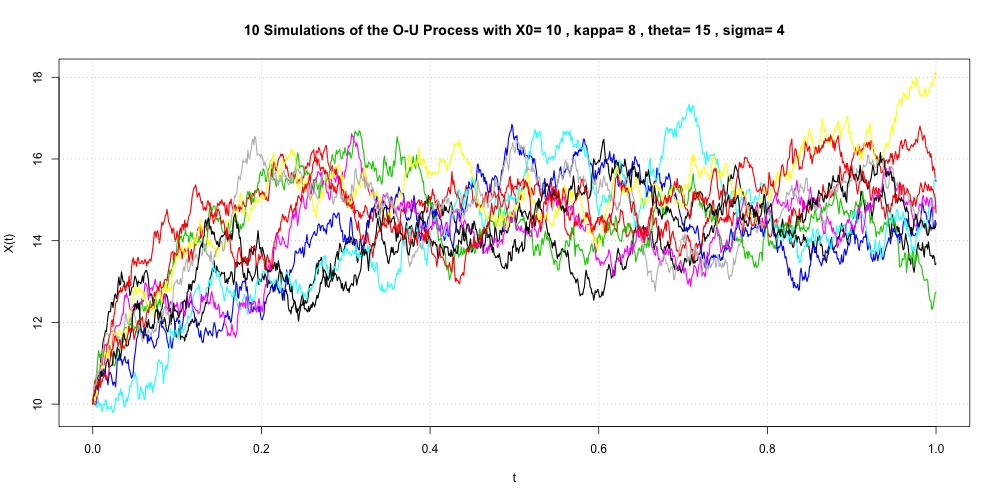

Try the below function to simulate some OU data

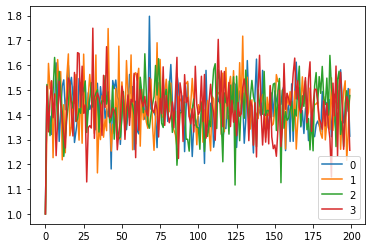

In [ ]:
import numpy as np
def simulate_ou(shape=(200, 4), theta=10, mu=10, sigma=0.1):
    dt = 1/shape[0]
    data = np.ones((shape))
    for i in range(1, len(data)):
        data[i] += mu * (theta - data[i-1]) * dt + sigma * np.random.normal(size=(shape[1]))
    return data

import pandas as pd
pd.DataFrame(simulate_ou()).plot()

### Computing the OU Coefficients ([source paper](https://arxiv.org/pdf/1411.5062.pdf)) 
I go over OU Processes and using it for Pairs Trading in this [video](https://youtu.be/RFj8SPuZ43Y).  
To calculate the coefficients, we maximize the (log) likelihood function:
$$-\frac{1}{2}ln(2\pi)-ln(\widetilde{\sigma})-\frac{1}{2n{\widetilde{\sigma}}^2}\sum_{i=1}^{n}[x_i-x_{i-1}e^{-\mu\Delta t}-\theta(1-e^{-\mu\Delta t})]^2$$  
where $\widetilde{\sigma}^2 = \sigma ^2\frac{1-e^{-2\mu\Delta t}}{2\mu}$,  
$x_i$ is the $ith$ value in our portfolio,  
n = the number of portfolio values,   
and ∆t = 1 ÷ (days between the start and end dates of the portfolio values),  
   
in order to choose the coefficients that best represent our time-series if it were treated as an OU process.  
Notes: 
-  We compute the log of the likelihood to prevent arithmetic underflow.  
-  We use $\theta$ for mean and $\mu$ for drift instead of $\mu$ for mean and $\theta$ for drift to follow the paper exactly

In [ ]:
# source for computation: https://arxiv.org/pdf/1411.5062.pdf
### IMPORTANT: PLEASE NOTE WE USE THETA FOR MEAN AND MU FOR DRIFT
### WHILE OTHER SOURCES, E.G. WIKIPEDIA, USES MU FOR MEAN AND THETA FOR DRIFT

import math
import scipy.optimize as so
import numpy as np
import tensorflow.keras.backend as K

def __neg_log_likelihood(params, *args):
    '''
    Compute the negative Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the negative log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)

    theta, mu, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - np.exp(-2 * mu * dt)) / (2 * mu)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * np.exp(-mu * dt) - theta * (1 - np.exp(-mu * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-np.log(2 * math.pi) / 2) + (-np.log(np.sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)

def __tf_neg_log_likelihood(X, theta, mu, sigma, dt):
    '''
    Computes and returns the negative log likelihood from the given parameters.
    Find in (2.2) in linked paper
    '''

    theta, mu, sigma, dt = tf.cast(theta, tf.float64), tf.cast(mu, tf.float64), tf.cast(sigma, tf.float64), tf.cast(dt, tf.float64)
    cast = lambda x: tf.cast(x, tf.float64)
    
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - K.exp(-2 * mu * dt)) / (2 * mu)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * K.exp(-mu * dt) - theta * (1 - K.exp(-mu * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = cast(-K.log(2 * math.pi) / 2) + cast(-K.log(K.sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood


def est_ou_coeffs(X, dt, tol=1e-4):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    inputs: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # theta ∈ ℝ, mu > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    theta_init = np.mean(X)
    initial_guess = (theta_init, 100, 100)  # initial guesses for theta, mu, sigma
    result = so.minimize(__neg_log_likelihood, initial_guess, args=(X, dt), bounds=bounds)
    theta, mu, sigma = result.x 
    max_log_likelihood = -result.fun  # undo negation from __neg_log_likelihood
    # .x gets the optimized parameters, .fun gets the optimized value
    return theta, mu, sigma, max_log_likelihood

### Neural Network model for Mean Reversion Optimization
We employ a Deep Neural Network to optimize asset allocations that create a portfolio with the highest fit to an OU process. To do this, we've set our objective (or loss in an ML context) function to the negative (log) likelihood so that Gradient Descent minimizes this value, which then in turn maximizes the non-negative (log) likelihood. This gets us the asset allocations that maximizes the (log) likelihood fit of a portfolio as an OU process. 
Some notes on the Model Architecture:  
- The concept of memory is applicable to time-series data, hence why we use an LSTM layer
- We use the $\tanh$ activation function to allow values between -1 and 1, which allows our optimizer to go both long and short on assets
- Since our model isn't predicting anything, we don't use the "true y values" argument in our custom defined loss function


In [ ]:
# inspiration for Neural Network: https://arxiv.org/pdf/2005.13665.pdf
import numpy as np
np.random.seed(123)  # this ensures reproduceability
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # this allows us to convert
tf.keras.backend.set_floatx('float64')  # this prevents random incompatible type errors
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import numpy as np
import scipy.optimize as so
import math

class OrnsteinUhlenbeckNeuralNet:  # Ornstein-Uhlenbeck Optimization Neural Network - 
    def __init__(self):
        self.data = None
        self.model = None
        self.theta = None
        self.mu = None
        self.sigma = None

    def __build_model(self, input_shape, outputs, dt):
        '''
        Builds a Deep Neural Network model with the parameters and returns the model

        inputs: input_shape - shape of the input layer of the NN
                outputs - number of output nodes of the NN, should be equal to the number of assets
                dt - dt of the OU MLE equation
        returns: Deep Neural Network model with given inputs 
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='tanh')
        ])

        def ou_loss(_, y_pred):
            '''
            Computes and returns the Likelihood for the given y_pred asset allocations
            
            We don't use the first argument as there are no "true y values" as we aren't
            using the model for prediction
            '''
            y_pred = y_pred / tf.reduce_sum(tf.abs(y_pred))  # normalize the sum of the magnitudes of the weights to 1
            
            coeffs = tf.tile(y_pred, (self.data.shape[0], 1))

            portfolio_values = tf.reduce_sum(tf.multiply(coeffs, self.data), axis=1)
            
            self.theta, self.mu, self.sigma, _ = est_ou_coeffs(portfolio_values.numpy(), dt)
            
            # we want to minimize the negative of the Likelihood, which maximizes the non-negated Likelihood
            return __tf_neg_log_likelihood(portfolio_values, self.theta, self.mu, self.sigma, dt)
        
        model.compile(loss=ou_loss, optimizer='adam')
        return model

    def fit(self, data):
        '''
        Optimizes the weights of the allocations to each asset to optimize the fit of a portfolio to an OU process
        and returns the θ, µ, σ, and asset allocations for this optimized OU process
        '''
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        data = data / data[0]  # normalize prices so they start at 1

        self.data = tf.cast(tf.constant(data), tf.float64)

        if self.model is None:
            self.model = self.__build_model(data.shape, data.shape[1], 1/len(data))

        data_new_axis = data[np.newaxis,:]
        
        self.model.fit(data_new_axis, np.zeros((1, data.shape[1])), epochs=20, shuffle=False, verbose=0)
        weights = self.model.predict(data_new_axis)[0] 
        weights = weights / np.sum(np.abs(weights))
        return self.theta, self.mu, self.sigma, weights

data = simulate_ou()

model = OrnsteinUhlenbeckNeuralNet()
model.fit(data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(-0.8153222314713269,
 598.0528670062241,
 1.711942425678703,
 array([-0.22562143, -0.29958092,  0.2162013 , -0.25859635]))

### Deriving the Optimal Entry and Liquidation values of the portfolio
Now that we have fitted our portfolio to an OU process, we now want to derive the Optimal Entry and Liquidation values based on the OU parameters. I've explained the method to the solutions previously [here](https://www.quantconnect.com/tutorials/strategy-library/optimal-pairs-trading#Optimal-Pairs-Trading-Method) under the **Deriving the Optimal Entry and Liquidation Levels** section of the **Method**.  
Our algorithm will buy the portfolio at the `Entry()` price and sell at the `Exit()` price. 

In [ ]:
# source for computation: https://arxiv.org/pdf/1411.5062.pdf
import mpmath as mp  # higher floating point precision, prevents arithmetic overflows
import scipy.optimize as so
import numpy as np

class OptimalStopping:
    '''
    Optimal Stopping Provides Functions for computing the Optimal Entry and Exit for our Pairs Portfolio

    Functions V and J are the functions used to calculate the Exit and Entry values, respectively
    '''
    def __init__(self, theta, mu, sigma, r=.05, c=.05):
        '''
        x - current portfolio value
        theta, mu, sigma - Ornstein-Uhlenbeck Coefficients
            (note we use self.theta for mean and self.mu for drift,
            while some sources use self.mu for mean and self.theta for drift)
        r - investor's subject discount rate
        c - cost of trading
        '''

        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.r = r
        self.c = c

        self.b_star = self.b()
        self.F_of_b = self.F(self.b_star)

        self.d_star = self.d()

    def UpdateFields(self, theta=None, mu=None, sigma=None, r=None, c=None):
        '''
        Update our OU Coefficients
        '''    
        if theta is not None:
            self.theta = theta
        if mu is not None:
            self.mu = mu
        if sigma is not None:
            self.sigma = sigma
        if r is not None:
            self.r = r
        if c is not None:
            self.c = c

        self.b_star = self.b()
        self.F_of_b = self.F(self.b_star)
        
        self.d_star = self.d()

    def Entry(self):
        '''
        Optimal value to enter/buy the portfolio
        '''
        return self.d_star
    
    def Exit(self):
        '''
        Optimal value to exit/liquidate the portfolio
        '''
        return self.b_star
    
    def V(self, x):
        # equation 4.2, solution of equation posed by 2.3

        if x < self.b_star:
            return (self.b_star - self.c) * self.F(x) / self.F_of_b
        else:
            return x - self.c

    def F(self, x):
        # equation 3.3
        def integrand(u):
            return u ** (self.r / self.mu - 1) * mp.exp(sqrt(2 * self.mu / self.sigma ** 2) * (x - self.theta) * u - u ** 2 / 2)

        return mp.quad(integrand, [0, mp.inf])

    def G(self, x):
        # equation 3.4
        def integrand(u):
            return u ** (self.r / self.mu - 1) * mp.exp(mp.sqrt(2 * self.mu / self.sigma ** 2) * (self.theta - x) * u - u ** 2 / 2)

        return mp.quad(integrand, [0, mp.inf])

    def b(self):
        # estimates b* using equation 4.3

        def func(b):
            return self.F(b) - (b - self.c) * self.Prime(self.F, b)

        # finds the root of function between the interval [0, 1]
        return so.brentq(func, 0, 1)

    def d(self):
        # estimates d* using equation 4.11

        def func(d):
            return (self.G(d) * (self.Prime(self.V, d) - 1)) - (self.Prime(self.G, d) * (self.V(d) - d - self.c))

        # finds the root of function between the interval [0, 1]
        return so.brentq(func, 0, 1)

    def Prime(self, f, x, h=1e-4):
        # given f, estimates f'(x) using the difference quotient formula 
        # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
        return (f(x + h) - f(x)) / h

### Backtesting
Since our algorithm only needs to buy and sell, we can create a simple backtester to test the performance of the this strategy. However, we need to make sure that we don't have look ahead bias.  
Steps:  
1.  Gather price data for various assets that will make up our portfolio. Our portfolio will consist of metals ETFs that include GLD (Gold), GDX (Gold Mining Companies), SLV (Silver), PPLT (Platinum).
2.  Create a simple backtester that will allow us to simulate the buying and selling of securities
3.  Do our computations on the price series to generate and backtest our rules
4.  Analyze the results


#### Gathering data

In [ ]:
!pip install yahoo_fin  # allows us to pull stock data
!pip install requests_html  # package required by yahoo_fin

In [ ]:
from yahoo_fin import stock_info
aapl_data = stock_info.get_data('AAPL', '01/01/2010', '01/01/2020')
aapl_data.head()

,open,high,low,close,adjclose,volume,ticker
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.539882,493729600,AAPL
2010-01-05,7.664286,7.699643,7.616071,7.656428,6.551187,601904800,AAPL
2010-01-06,7.656428,7.686786,7.526786,7.534643,6.446983,552160000,AAPL
2010-01-07,7.562500,7.571429,7.466072,7.520714,6.435065,477131200,AAPL
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.477847,447610800,AAPL


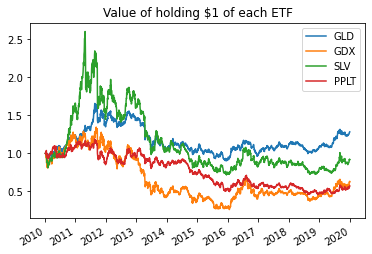

In [ ]:
tickers = ['GLD', 'GDX', 'SLV', 'PPLT']
start_date = '01/01/2010'
end_date = '01/01/2020'

series = []

for ticker in tickers:
    data = stock_info.get_data(ticker, start_date, end_date)
    series.append(data['adjclose'].rename(ticker))

df = pd.concat(series, axis=1).dropna()  # concatenate the series into one DataFrame
                                         # we apply dropna to ensure all price series start at the same date
(df / df.iloc[0]).plot(title='Value of holding $1 of each ETF')

#### Backtester
Q: Why not use an existing backtesting framework?  
A: We require a very simple backtester, thus we don't need to introduce a new element that someone would need to learn

In [ ]:
!pip install trade-stat-logger  # library to allow us to log our trades

Create the template class that we will extend

In [ ]:
from trade_stat_logger.logger import SimpleLogger
from typing import Dict
# from typing import final - not supported in current Colab version

class Algorithm:
    def __init__(self, cash=100000, margin=.95):
        self.margin = margin  # margin for setHoldings, prevents us from going negative on cash
        self.cash = cash
        self.__orders = {}
        self.logger = SimpleLogger()
        self.__data = None
        self.t = 0

        self.initialize()

    def initalize(self):
        pass

    def onData(self, data:Dict[str, float]):
        pass

    #@final
    def onDataBacktest(self, data:Dict[str, float]):
        self.__data = data
        self.__fillOrders(data)
        self.onData(data)
        self.t += 1
    
    #@final
    def order(self, ticker:str, quantity:int):
        if ticker not in self.__orders:
            self.__orders[ticker] = 0
        self.__orders[ticker] += quantity
    
    #@final
    def setHoldings(self, holdings:Dict[str, float]):
        total_pct = sum(holdings.values())
        if total_pct > 1:
            {ticker:pct/total_pct for ticker, pct in holdings.items()}

        for ticker, pct in holdings.items():
            curr_shares = self.logger.get_position(ticker)[0]
            target_shares = int(self.cash * (pct * self.margin) / self.__data[ticker])
            self.order(ticker, target_shares - curr_shares)
    
    def liquidate(self):
        self.setHoldings({ticker:0 for ticker in self.__data.keys()})

    def __fillOrders(self, data):
        for ticker in self.__orders:
            quantity = self.__orders[ticker]
            self.cash -= quantity * data[ticker]
            self.logger.log(ticker, quantity, data[ticker])
            self.__orders[ticker] = 0

Extend the template `Algorithm` class and fill in `initialize` and `onData`

In [ ]:
from collections import deque

class MeanReversionAlgo(Algorithm):
    def initialize(self):
        self.data = deque(maxlen=200)
        self.model = OrnsteinUhlenbeckNeuralNet()
        self.portfolio = None
        self.is_invested = False
        self.weights = {}

    def onData(self, bar):
        self.data.append(bar)
        if len(self.data) != self.data.maxlen:
            return
        
        if self.t % 200 == 0:
            self.retrain(bar, pd.DataFrame(self.data))
        
        if self.portfolio is None:
            return

        self.portfolio.update(bar)

        if self.portfolio.isBuy() and not self.is_invested:
            self.is_invested = True
            self.setHoldings(self.weights)
        elif self.portfolio.isSell() and self.is_invested:
            self.is_invested = False
            self.liquidate()

    def retrain(self, bar, df):
        theta, mu, sigma, weights = self.model.fit(df)
        if theta < 0:
            theta = -theta
            weights = -weights
        self.weights = {ticker:weight for ticker, weight in zip(bar.keys(), weights)}
        print('theta:', theta, 'mu:', mu, 'sigma:', sigma)
        
        try:
            opt_stopping = OptimalStopping(theta, mu, sigma)
            self.portfolio = Portfolio(bar, self.weights, opt_stopping)
            print('Entry:', opt_stopping.Entry(), 'Exit:', opt_stopping.Exit())
        except Exception as e:
            self.portfolio = None
            self.weights = {}
            self.liquidate()
            return
        
class Portfolio:
    def __init__(self, init_prices:Dict[str, float], weights, opt_stopping):
        self.init_prices = init_prices
        self.curr_prices = init_prices
        self.weights = weights
        self.opt_stopping = opt_stopping

    def update(self, curr_prices):
        self.curr_prices = curr_prices

    def isBuy(self):
        return self.value() < self.opt_stopping.Entry()
    
    def isSell(self):
        return self.value() > self.opt_stopping.Exit()

    def value(self):
        return sum([curr_price / self.init_prices[ticker] * self.weights[ticker] for ticker, curr_price in self.curr_prices.items()])


Feed data into our algorithm

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


theta: 0.4002755095689392 mu: 17.951571758062638 sigma: 0.04863458861593988
Entry: 0.271593833380003 Exit: 0.397335742571316
theta: 0.31896487751082087 mu: 1e-05 sigma: 0.06322998664456723
theta: 0.25105991360877544 mu: 10.29814408893501 sigma: 0.05700831381448093
Entry: 0.13777472789908982 Exit: 0.25992838770498855
theta: 0.24434909868782678 mu: 11.285845359068794 sigma: 0.03882805778716699
Entry: 0.12827983451328748 Exit: 0.247104962354493
theta: 0.21359426707461523 mu: 120.21413098628013 sigma: 0.06895812309324026
Entry: 0.09886000979999551 Exit: 0.21324838164065912
theta: 0.2703289673134799 mu: 9.20214287513656 sigma: 0.03853672266044647
Entry: 0.15202558139374628 Exit: 0.2728675174074879
theta: 0.26565634444519226 mu: 120.2157674518596 sigma: 0.07121439496769971
Entry: 0.1465378246593102 Exit: 0.26373229901034845
theta: 0.2804258809167389 mu: 4.833501278641394 sigma: 0.05122846752648027
Entry: 0.16477766720619097 Exit: 0.2923588870029109
theta: 0.32976044861072035 mu: 11.843199094

/usr/local/lib/python3.6/dist-packages/trade_stat_logger/logger.py:115: UserWarning: For most accurate performance results, please clear all holdings, which you can do with clear_all_positions()
  warn('For most accurate performance results, please clear all holdings, which you can do with clear_all_positions()')


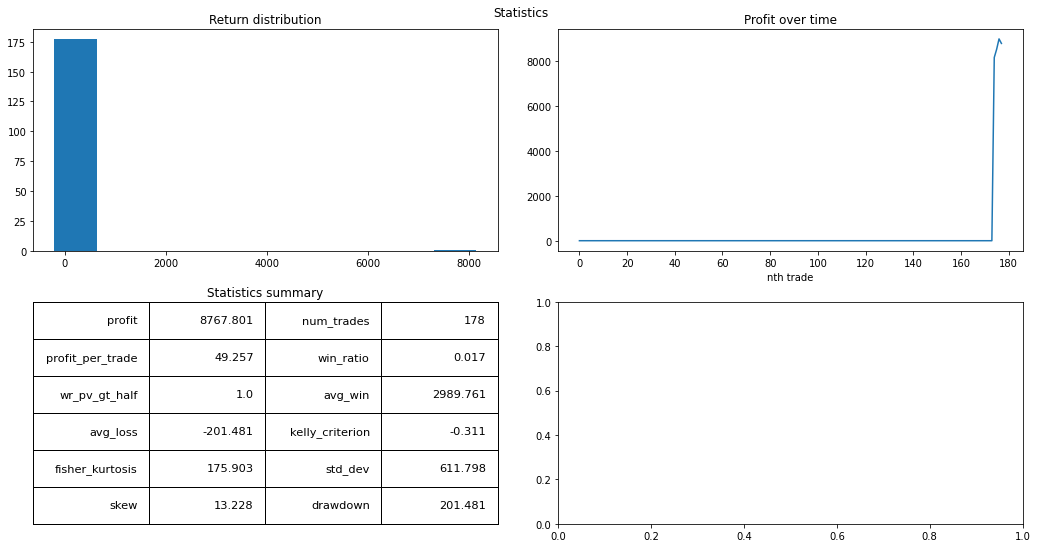

In [ ]:
def backtest(df:pd.DataFrame, algo:Algorithm):
    for idx, row in df.iterrows():
        algo.onDataBacktest(row.to_dict())
    algo.logger.graph_statistics()
backtest(df, MeanReversionAlgo())